In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sea
import re
from astropy.io import fits
from astropy.table import Table
from grizli import model as griz_model
from scipy.interpolate import interp1d
from spec_tools import Get_Sensitivity, Scale_model
import pysynphot as S
from time import time
import os
from glob import glob
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

(0, 1.5e-18)

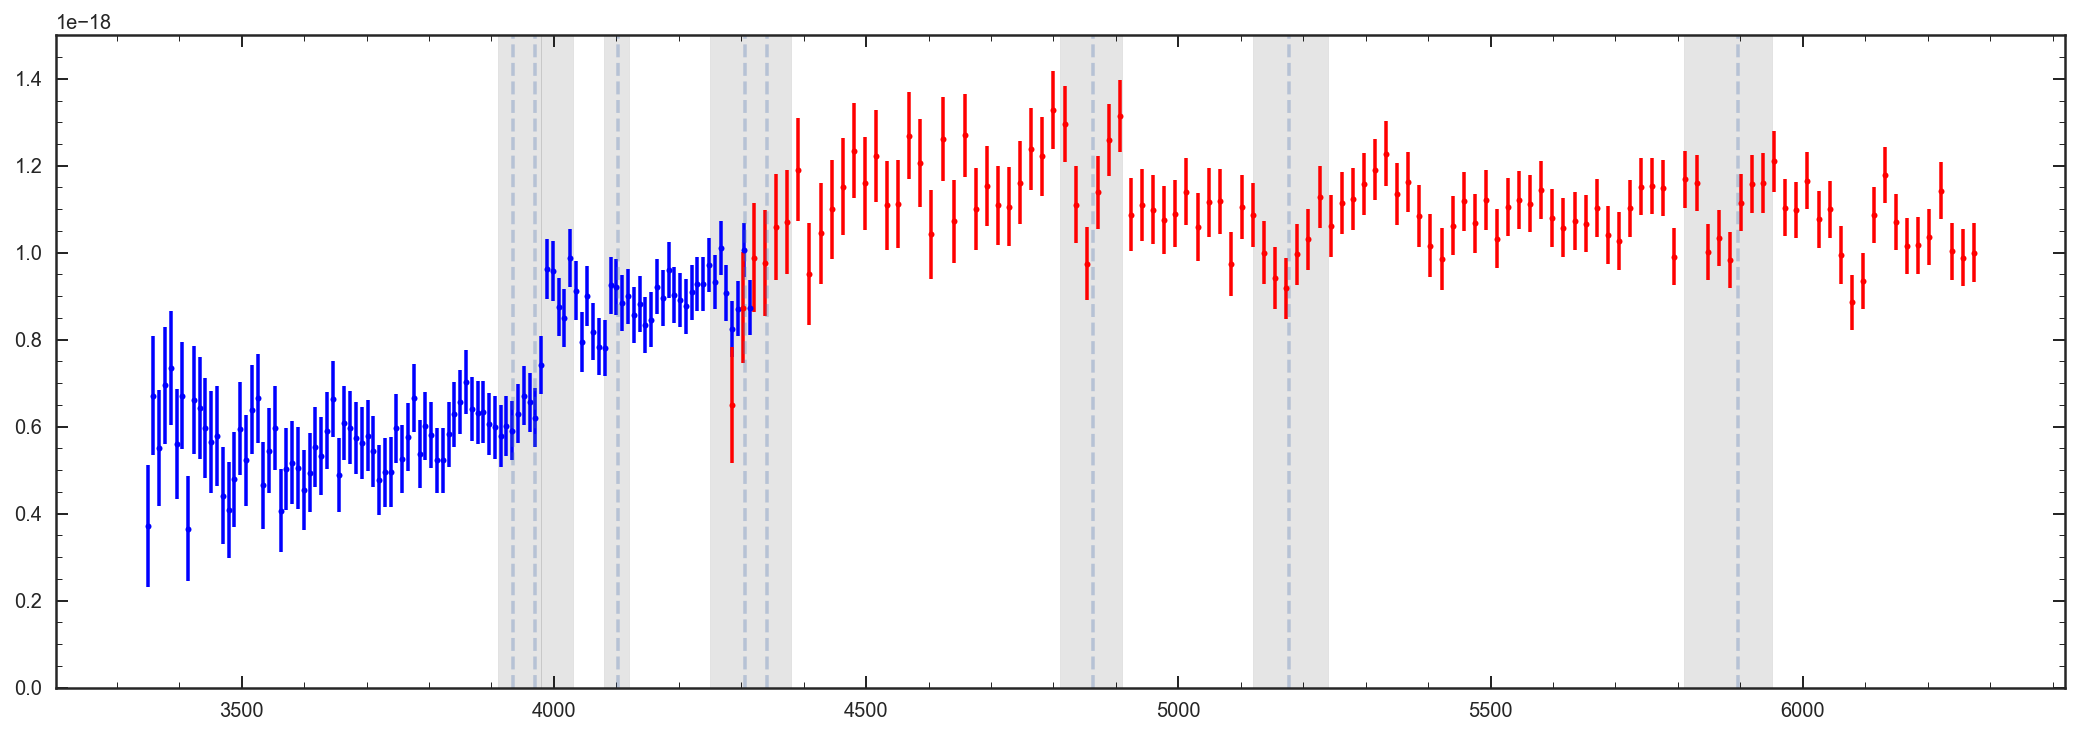

In [61]:
#2.603
plt.figure(figsize=[18,6])
plt.errorbar(sp.g102_wv/2.61, sp.g102_fl, sp.g102_er, linestyle='None', marker='o', markersize=3, color='b')

plt.errorbar(sp.g141_wv/2.61, sp.g141_fl, sp.g141_er, linestyle='None', marker='o', markersize=3, color='r')
# plt.errorbar(phot_db['eff_wv'],phot_db['phot'] ,phot_db['phot_err'],
#              color='#BC344F',fmt='s',ms=10,label='Broad-Band Photometry', zorder=2)
# plt.errorbar(sp.stack_wv, sp.stack_fl, sp.stack_er, linestyle='None', marker='o', markersize=3, color='k')
plt.axvline(3934.777,linestyle='--', alpha=.3)
plt.axvline(3969.588,linestyle='--', alpha=.3)
plt.axvline(4102.89,linestyle='--', alpha=.3)
plt.axvline(4305.61,linestyle='--', alpha=.3)
plt.axvline(4341.68,linestyle='--', alpha=.3)
plt.axvline(4862.68,linestyle='--', alpha=.3)
plt.axvline(5176.7,linestyle='--', alpha=.3)
plt.axvline(5895.6,linestyle='--', alpha=.3)

plt.axvspan(3910, 3980, color='k', alpha=.1)
plt.axvspan(3980, 4030, color='k', alpha=.1)
plt.axvspan(4080, 4120, color='k', alpha=.1)
plt.axvspan(4250, 4380, color='k', alpha=.1)
plt.axvspan(4810, 4910, color='k', alpha=.1)
plt.axvspan(5120, 5240, color='k', alpha=.1)
plt.axvspan(5810, 5950, color='k', alpha=.1)

# plt.xlim(8000,17000)
plt.ylim(0,1.5E-18)
# plt.savefig('GS41520_combspec.png')

# g102 and g141 stack test

<ErrorbarContainer object of 3 artists>

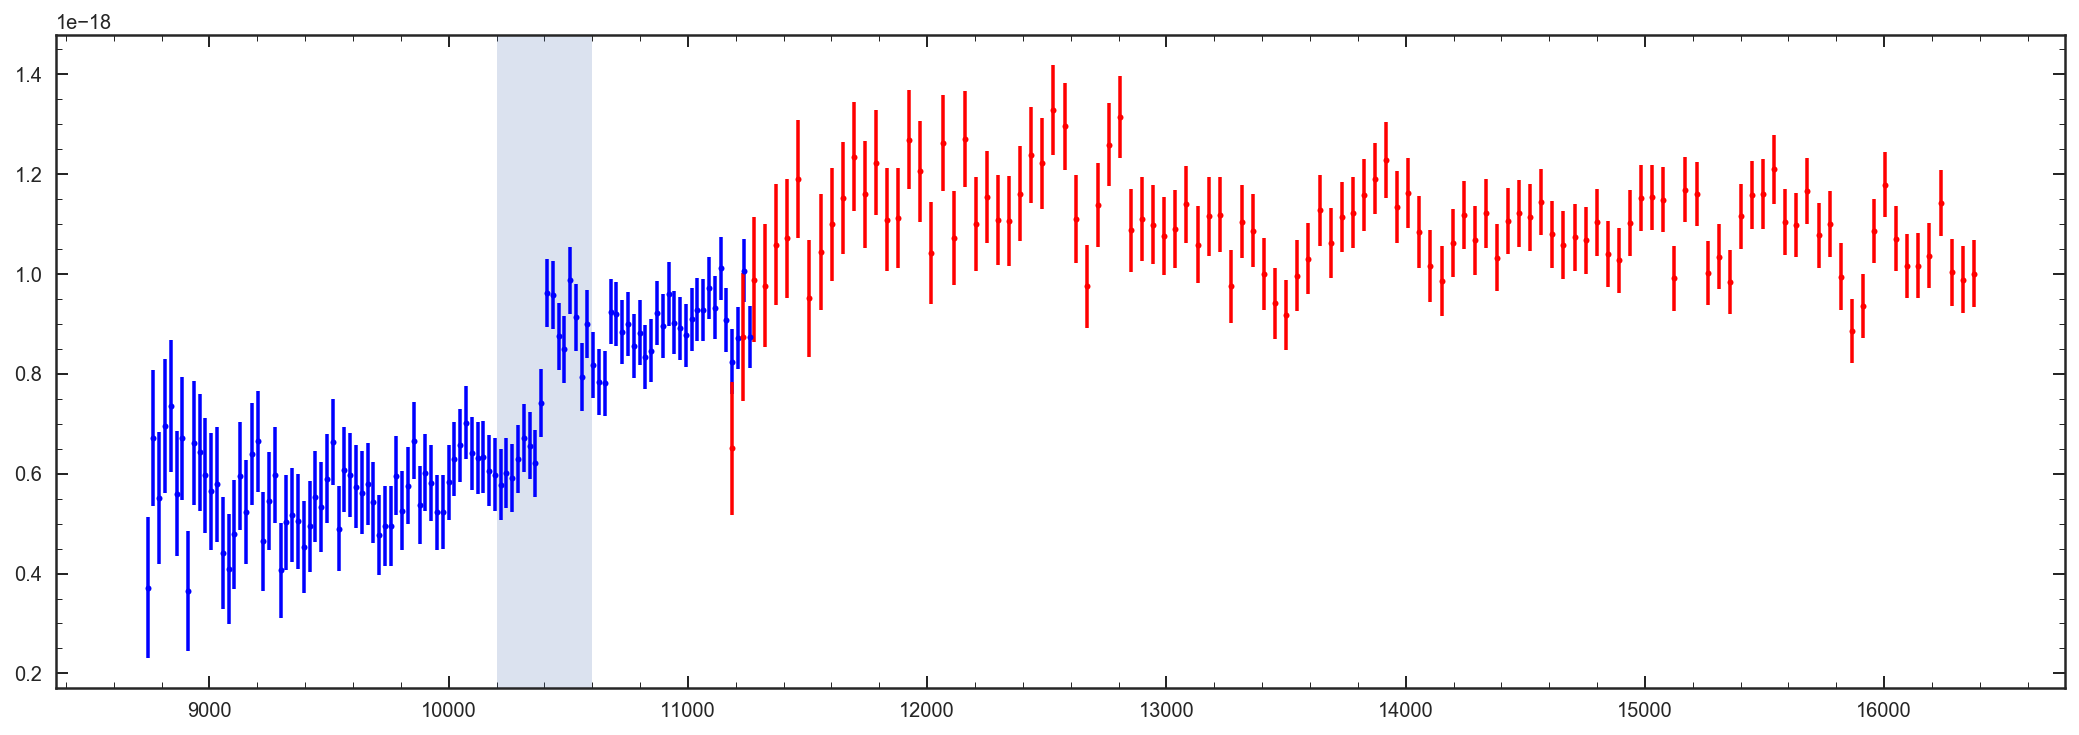

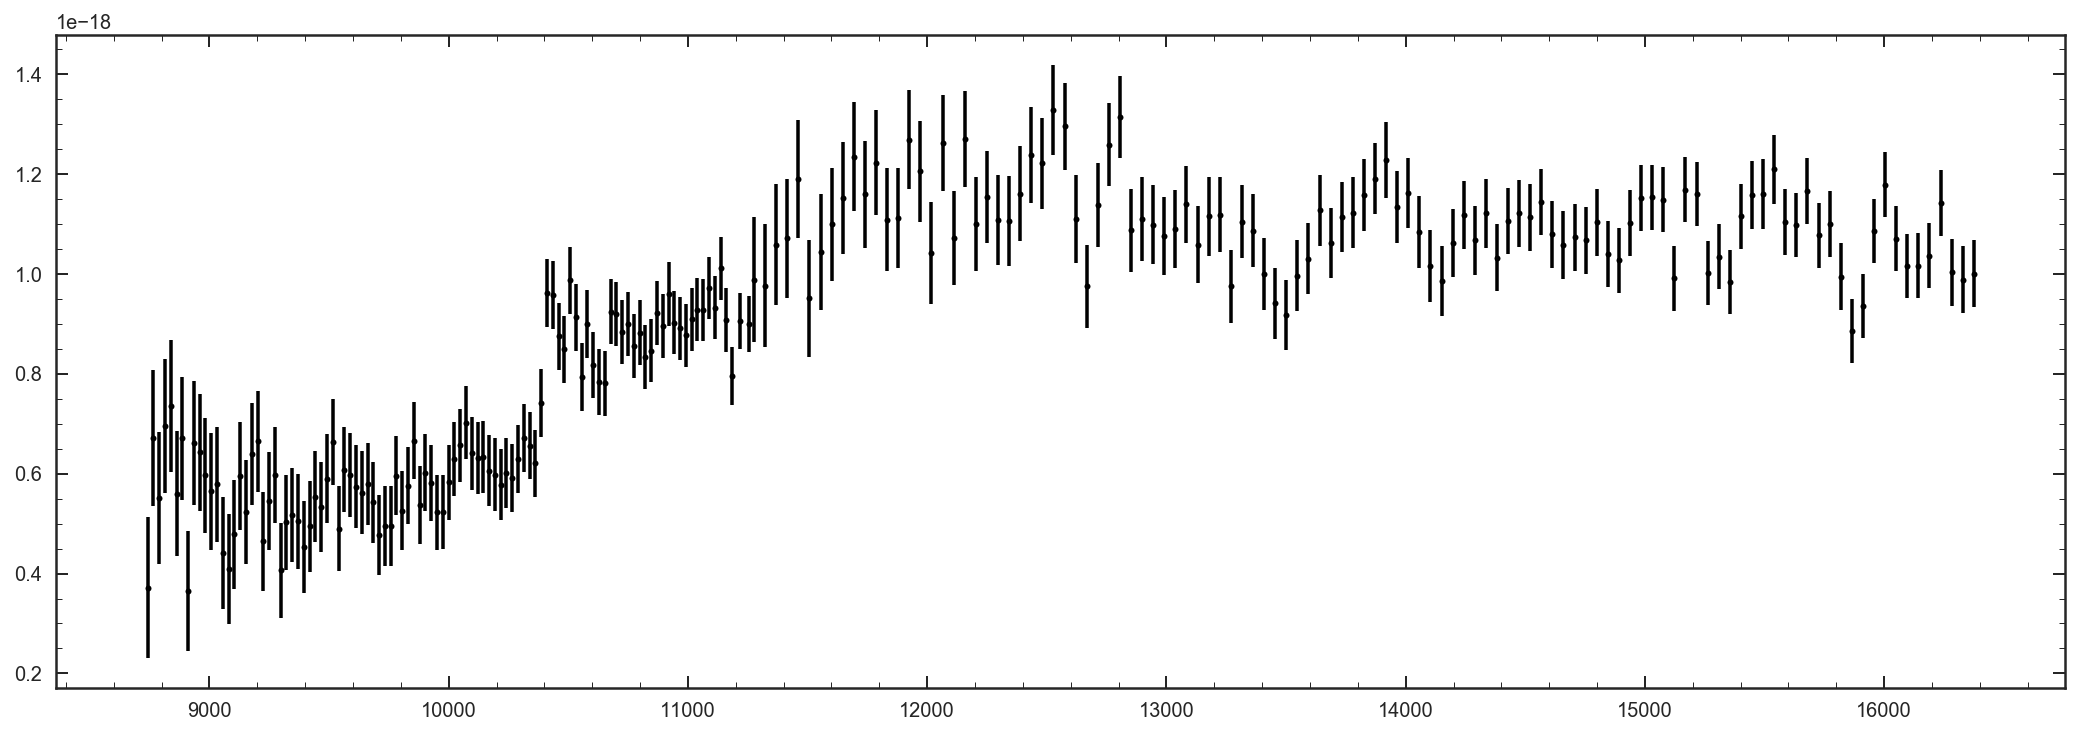

In [60]:
plt.figure(figsize=[18,6])
plt.errorbar(sp.g102_wv, sp.g102_fl, sp.g102_er, linestyle='None', marker='o', markersize=3, color='b')
plt.errorbar(sp.g141_wv, sp.g141_fl, sp.g141_er, linestyle='None', marker='o', markersize=3, color='r')
plt.axvspan(2.55 * 4000,2.65 * 4000,alpha=.2)

plt.figure(figsize=[18,6])
plt.errorbar(sp.stack_wv, sp.stack_fl, sp.stack_er, linestyle='None', marker='o', markersize=3, color='k')

In [238]:
bounds = [min(sp.g141_wv),max(sp.g102_wv)]
del_g102 = sp.g102_wv[1] - sp.g102_wv[0]
del_g141 = sp.g141_wv[1] - sp.g141_wv[0]
del_mix = (del_g102 + del_g141) / 2
mix_wv = np.arange(bounds[0],bounds[1],del_mix)

In [240]:
mix_wv

array([11183.74044821, 11219.01011362, 11254.27977903])

In [245]:
new_wv = np.append(np.append(sp.g102_wv[sp.g102_wv < bounds[0]],mix_wv),sp.g141_wv[sp.g141_wv > bounds[1]])

In [249]:
stack_wv = new_wv

flgrid = np.zeros([2, len(stack_wv)])
errgrid = np.zeros([2, len(stack_wv)])

# Get wv,fl,er for each spectra
for i in range(len(stack_wv)):
    if min(sp.g102_wv) <= stack_wv[i] <= max(sp.g102_wv):
        flgrid[0][i] = interp1d(sp.g102_wv, sp.g102_fl)(stack_wv[i])
        errgrid[0][i] = interp1d(sp.g102_wv, sp.g102_er)(stack_wv[i])
        
    if min(sp.g141_wv) <= stack_wv[i] <= max(sp.g141_wv):
        flgrid[1][i] = interp1d(sp.g141_wv, sp.g141_fl)(stack_wv[i])
        errgrid[1][i] = interp1d(sp.g141_wv, sp.g141_er)(stack_wv[i])
################

flgrid = np.transpose(flgrid)
errgrid = np.transpose(errgrid)
weigrid = errgrid ** (-2)
infmask = np.isinf(weigrid)
weigrid[infmask] = 0
################

stack, err = np.zeros([2, len(stack_wv)])
for i in range(len(stack_wv)):
    stack[i] = np.sum(flgrid[i] * weigrid[[i]]) / (np.sum(weigrid[i]))
    err[i] = 1 / np.sqrt(np.sum(weigrid[i]))
################


stack_fl = np.array(stack)
stack_er = np.array(err)

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in power


In [53]:
dat = pd.read_pickle('../../Quiescent_analysis/data/phot_db.pkl')

In [14]:
beams=glob('../beams/*41520*')

In [15]:
indat = fits.open(beams[0])

In [16]:
print(indat[1].header['PHOTFLAM'])
print(indat[1].header['EXPTIME'])


1
1102.935669


<ErrorbarContainer object of 3 artists>

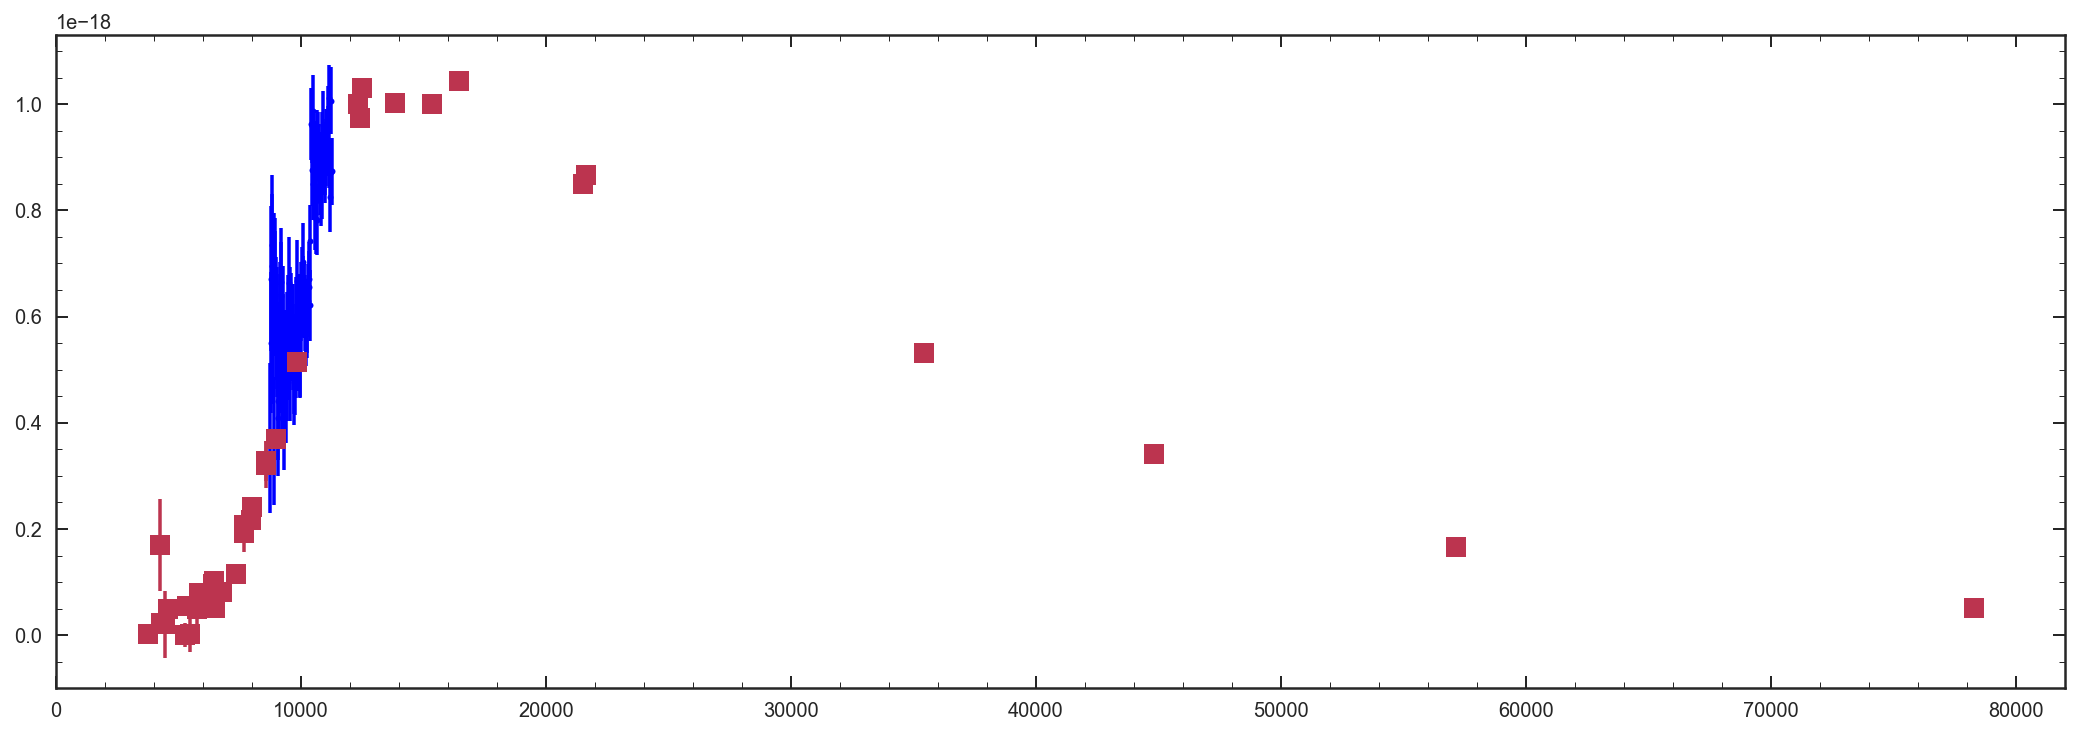

In [48]:
plt.figure(figsize=[18,6])

factor = 1

plt.errorbar(sp.g102_wv, sp.g102_fl*factor, sp.g102_er*factor, linestyle='None', marker='o', markersize=3, color='b')

# plt.errorbar(sp.g141_wv, sp.g141_fl, sp.g141_er, linestyle='None', marker='o', markersize=3, color='r')
plt.errorbar(phot_db['eff_wv'],phot_db['phot'] ,phot_db['phot_err'],
             color='#BC344F',fmt='s',ms=10,label='Broad-Band Photometry', zorder=2)


# make gen spec

In [43]:
class Gen_spec(object):
    def __init__(self, gal_id, g102_min = 8700, g102_max = 11400, g141_min = 11100, g141_max = 16700, sim = True):
        self.gal_id = gal_id
        
        self.g102_list = glob('../beams/*{0}*g102*'.format(gal_id))
        self.g141_list = glob('../beams/*{0}*g141*'.format(gal_id))
        self.g102_wv, self.g102_fl, self.g102_er = self.Stack_1d_beams(self.g102_list,g102_min,g102_max) 
        self.g141_wv, self.g141_fl, self.g141_er = self.Stack_1d_beams(self.g141_list,g141_min,g141_max) 
        
        self.Stack_g102_g141()
        
        if sim == True:
            self.Initialize_sim()
            self.g102_sens = self.Set_sensitivity(self.g102_list[0],self.g102_wv)
            self.g141_sens = self.Set_sensitivity(self.g141_list[0],self.g141_wv)

    def Single_spec(self, beam, min_wv, max_wv):
        BEAM = griz_model.BeamCutout(fits_file= beam)

#         spec_2D = BEAM.grism.data['SCI']
#         contam_2D = BEAM.contam
#         clean_2D = BEAM.grism.data['SCI'] - BEAM.contam
#         cutout = BEAM.beam.direct*(BEAM.beam.seg == self.gal_id)

        # (mask bad pixel)
        BEAM.cutout_seg[(BEAM.thumb/BEAM.photflam > 100) | (BEAM.thumb < 0)] = 0
        BEAM.total_flux = np.sum(BEAM.thumb[BEAM.cutout_seg == BEAM.id])

        ### Compute the model in the FLT frame for a single object
        model_id = flt.compute_model(id=id, x=x0, y=y0, sh=[80,80], in_place=False).reshape(flt.sh_pad)
        beam.contam = beam.get_cutout(flt.model-model_id)    
    
    
    
        ivar = BEAM.ivar
        weight = np.exp(-(1*np.abs(BEAM.contam)*np.sqrt(ivar)))
            
        cln = np.array(BEAM.grism.data['SCI']-BEAM.contam)
        cln[cln < 0] = 0
            
        w, f, e = BEAM.beam.optimal_extract(BEAM.cutout_sci, bin=0, ivar=BEAM.ivar)#,weight=weight) #data

#         w, f, e = BEAM.beam.optimal_extract(cln, bin=0, ivar=BEAM.ivar,weight=weight) #data

        
        testw, testf, teste = BEAM.beam.optimal_extract(BEAM.grism.data['SCI'], bin=0, ivar=BEAM.ivar) #data
        conw, conf, cone = BEAM.beam.optimal_extract(BEAM.contam, bin=0, ivar=BEAM.ivar) #data       
        
        flat = BEAM.flat_flam.reshape(BEAM.beam.sh_beam)
        fwave,fflux,ferr = BEAM.beam.optimal_extract(flat, bin=0, ivar=BEAM.ivar)

#         e = np.sqrt(e**2 + conf**2)

        f /= fflux
        e /= fflux

        IDX= [U for U in range(len(w)) if min_wv < w[U] < max_wv]
        
#         plt.figure(figsize=[15,8])
#         plt.plot(w[IDX],f[IDX])
#         plt.plot(testw[IDX],testf[IDX] / fflux[IDX])
#         plt.plot(conw[IDX],conf[IDX]/ fflux[IDX])
#         plt.plot(w[IDX],e[IDX],'b--')
# #         plt.plot(testw[IDX],teste[IDX] / fflux[IDX],'r--')
#         plt.title(beam)

        return w[IDX], f[IDX], e[IDX]
        
    def Set_sensitivity(self,beam,master_wv):    
        BEAM = griz_model.BeamCutout(fits_file= beam)
        
        flat = BEAM.flat_flam.reshape(BEAM.beam.sh_beam)
        fwave,fflux,ferr = BEAM.beam.optimal_extract(flat, bin=0, ivar=BEAM.ivar)

        return interp1d(fwave,fflux)(master_wv)
        
    def Stack_spec(self, stk_wv, flgrid, errgrid):
        #### rearrange flux grid and generate weights
        flgrid = np.transpose(flgrid)
        errgrid = np.transpose(errgrid)
        weigrid = errgrid ** (-2)
        infmask = np.isinf(weigrid) ## remove inif cause by nans in the error grid
        weigrid[infmask] = 0

        #### Stack spectra
        stack_fl, stack_er = np.zeros([2, len(stk_wv)])
        for i in range(len(stk_wv)):
            stack_fl[i] = np.sum(flgrid[i] * weigrid[[i]]) / (np.sum(weigrid[i]))
            stack_er[i] = 1 / np.sqrt(np.sum(weigrid[i]))
        
        return stk_wv, stack_fl, stack_er
        
    def Stack_1d_beams(self, beam_list, min_wv, max_wv):
        #### set master wavelength array
        wv,fl,er = self.Single_spec(beam_list[0], min_wv = min_wv, max_wv=max_wv)
        master_wv = wv[1:-1]
        
        #### intialize flux and error grid
        flgrid = np.zeros([len(beam_list), len(master_wv)])
        errgrid = np.zeros([len(beam_list), len(master_wv)])

        #### Get wv,fl,er for each spectra
        for i in range(len(beam_list)):
            wv,fl,er = self.Single_spec(beam_list[i], min_wv = min_wv, max_wv=max_wv)
            flgrid[i] = interp1d(wv, fl)(master_wv)
            errgrid[i] = interp1d(wv, er)(master_wv)
        
        return self.Stack_spec(master_wv, flgrid, errgrid)

    
    def Stack_g102_g141(self): #### good to display, but may not be good for science
        #### make combined wavelength set
        bounds = [min(self.g141_wv),max(self.g102_wv)]
        del_g102 = self.g102_wv[1] - self.g102_wv[0]
        del_g141 = self.g141_wv[1] - self.g141_wv[0]
        del_mix = (del_g102 + del_g141) / 2
        mix_wv = np.arange(bounds[0],bounds[1],del_mix)    
        stack_wv = np.append(np.append(self.g102_wv[self.g102_wv < bounds[0]],mix_wv),self.g141_wv[self.g141_wv > bounds[1]])

        #### intialize flux and error grid
        flgrid = np.zeros([2, len(stack_wv)])
        errgrid = np.zeros([2, len(stack_wv)])

        #### Get wv,fl,er for each spectra
        for i in range(len(stack_wv)):
            if min(self.g102_wv) <= stack_wv[i] <= max(self.g102_wv):
                flgrid[0][i] = interp1d(self.g102_wv, self.g102_fl)(stack_wv[i])
                errgrid[0][i] = interp1d(self.g102_wv, self.g102_er)(stack_wv[i])

            if min(self.g141_wv) <= stack_wv[i] <= max(self.g141_wv):
                flgrid[1][i] = interp1d(self.g141_wv, self.g141_fl)(stack_wv[i])
                errgrid[1][i] = interp1d(self.g141_wv, self.g141_er)(stack_wv[i])

        self.stack_wv, self.stack_fl, self.stack_er = self.Stack_spec(stack_wv, flgrid, errgrid)
        
    def Initialize_sim(self):
        #### pick out orients
        g102_beams = glob('../beams/*{0}*g102*'.format(self.gal_id))
        g102_beamid = [re.findall("o\w[0-9]+",U)[0] for U in g102_beams]
        self.g102_beamid = list(set(g102_beamid))

        g141_beams = glob('../beams/*{0}*g141*'.format(self.gal_id))
        g141_beamid = [re.findall("o\w[0-9]+",U)[0] for U in g141_beams]
        self.g141_beamid = list(set(g141_beamid))
        
        #### initialize dictionary of beams
        self.g102_beam_dict = {}
        self.g141_beam_dict = {}

        #### set beams for each orient
        for i in self.g102_beamid:
            key = i
            value = griz_model.BeamCutout(fits_file= glob('../beams/*{0}*{1}*g102*'.format(i,self.gal_id))[0])
            self.g102_beam_dict[key] = value 
            
        for i in self.g141_beamid:
            key = i
            value = griz_model.BeamCutout(fits_file= glob('../beams/*{0}*{1}*g141*'.format(i,self.gal_id))[0])
            self.g141_beam_dict[key] = value 
        
    def Sim_beam(self,BEAM, mwv, mfl, grism_wv, grism_fl, grism_er, grism_sens):
        ## Compute the models
        BEAM.beam.compute_model(spectrum_1d=[mwv, mfl], is_cgs = True)

        ## Extractions the model (error array here is meaningless)
        w, f, e = BEAM.beam.optimal_extract(BEAM.beam.model, bin=0)

        ## interpolate and scale
        f = interp1d(w,f)(grism_wv) / grism_sens
        C = Scale_model(grism_fl, grism_er,f)

        return C*f
            
    def Gen_sim(self, model_wv, model_fl, redshift): 
        ### normalize and redshift model spectra
        spec = S.ArraySpectrum(model_wv, model_fl, fluxunits='flam')
        spec = spec.redshift(redshift).renorm(1., 'flam', S.ObsBandpass('wfc3,ir,f105w'))
        spec.convert('flam')

        ### initialize model flux grids
        g102_mfl_grid = np.zeros([len(self.g102_beam_dict.keys()), len(self.g102_wv)])
        g141_mfl_grid = np.zeros([len(self.g141_beam_dict.keys()), len(self.g141_wv)])

        ### simulate each beam
        for i in range(len(self.g102_beamid)):    
            g102_mfl_grid[i] = self.Sim_beam(self.g102_beam_dict[self.g102_beamid[i]], spec.wave,spec.flux, 
                                             self.g102_wv, self.g102_fl, self.g102_er, self.g102_sens)

        for i in range(len(self.g141_beamid)):    
            g141_mfl_grid[i] = self.Sim_beam(self.g141_beam_dict[self.g141_beamid[i]], spec.wave,spec.flux, 
                                             self.g141_wv, self.g141_fl, self.g141_er, self.g141_sens)

        ### stack all sims
        self.g102_mfl = np.mean(g102_mfl_grid,axis=0)
        self.g141_mfl = np.mean(g141_mfl_grid,axis=0)

In [44]:
sp =Gen_spec(41520,g102_min=8000)

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3422: RuntimeWarning: invalid value encountered in sqrt
  resid = np.abs(self.scif - self.flat_flam)*np.sqrt(self.ivarf)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3427: RuntimeWarning: invalid value encountered in sqrt
  contam_mask = ((self.contam*np.sqrt(self.ivar) > contam_sn_mask[0]) &
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3428: RuntimeWarning: invalid value encountered in sqrt
  (self.model*np.sqrt(self.ivar) < contam_sn_mask[1]))
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in sqrt


AttributeError: 'BeamCutout' object has no attribute 'cutout_sci'

In [32]:
model_wv,model_fl = np.load(hpath + 'fsps_models_for_fit/fsps_spec/m0.019_a1.0_dt0_spec.npy')
sp.Gen_sim(model_wv, model_fl,1.6)

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: divide by zero encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


AttributeError: 'Gen_spec' object has no attribute 'g102_mfl'

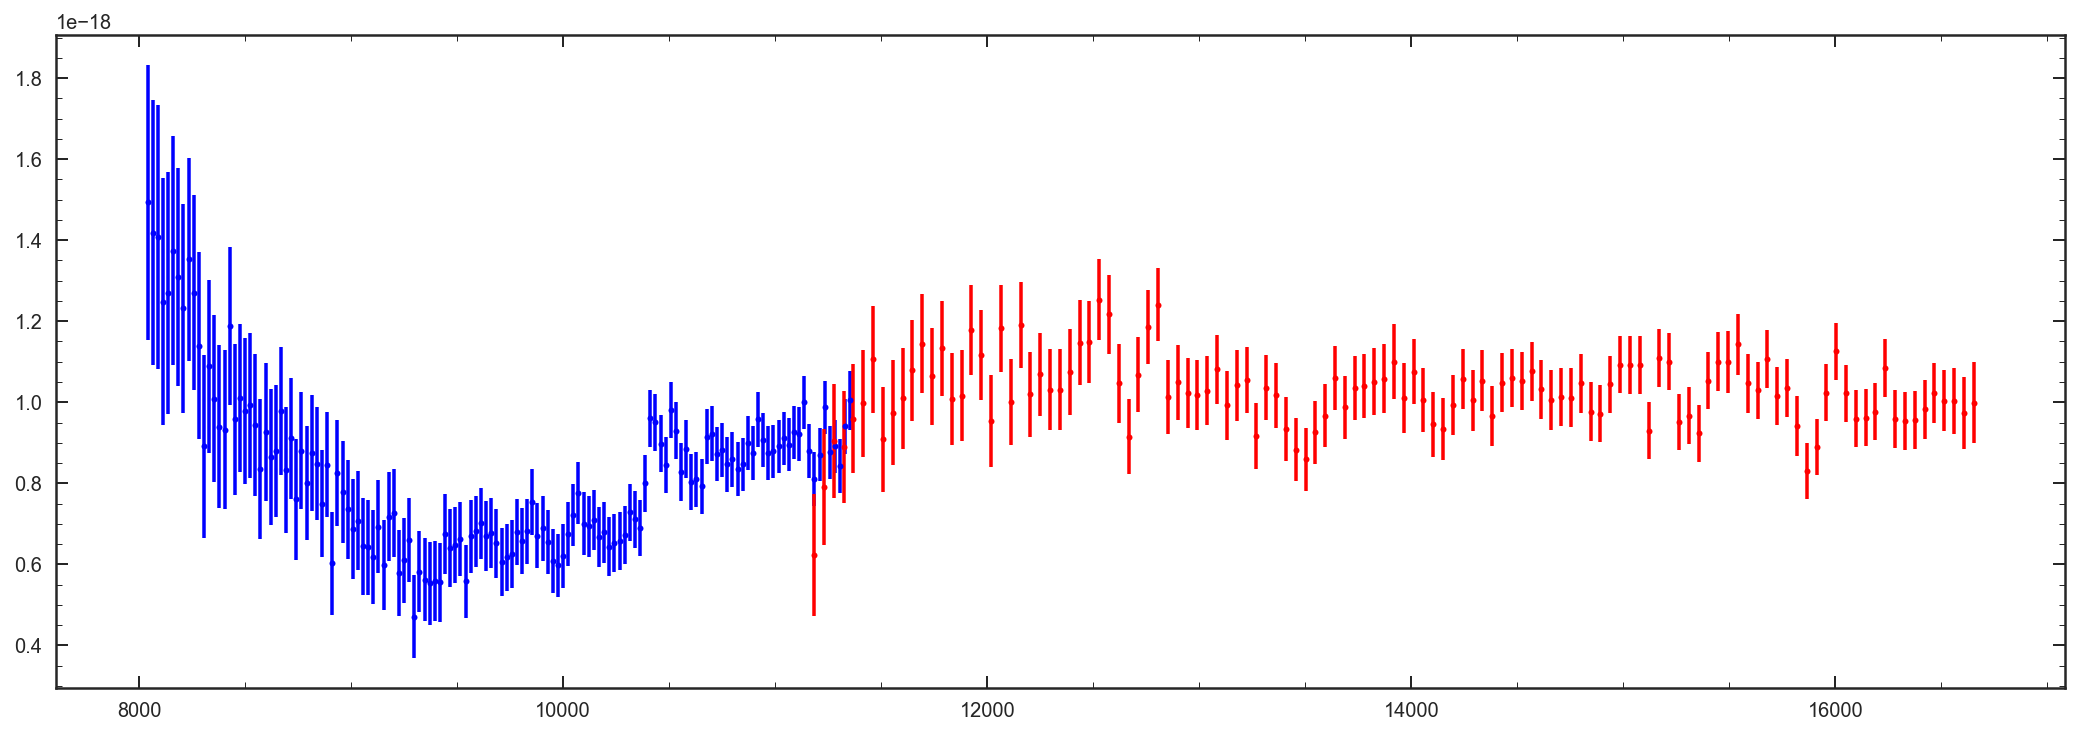

In [42]:
plt.figure(figsize=[18,6])
plt.errorbar(sp.g102_wv,sp.g102_fl,sp.g102_er,linestyle='None', marker='o', markersize=3, color='b')
plt.errorbar(sp.g141_wv,sp.g141_fl,sp.g141_er,linestyle='None', marker='o', markersize=3, color='r')
plt.plot(sp.g102_wv,sp.g102_mfl,'k')
plt.plot(sp.g141_wv,sp.g141_mfl,'k')


In [11]:
dat = fits.open('../beams/o193_1_41520.g102.A.fits')

In [3]:
dat.info()

Filename: ../beams/o193_1_41520.g102.A.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      15   ()      
  1  SCI           1 ImageHDU       197   (54, 54)   float32   
  2  ERR           1 ImageHDU       197   (54, 54)   float32   
  3  DQ            1 ImageHDU       197   (54, 54)   int16   
  4  REF           1 ImageHDU       198   (54, 54)   float32   
  5  SEG           1 ImageHDU       198   (54, 54)   int32   
  6  SCI           2 ImageHDU       197   (261, 54)   float32   
  7  ERR           2 ImageHDU       197   (261, 54)   float32   
  8  DQ            2 ImageHDU       197   (261, 54)   int16   
  9  CONTAM        2 ImageHDU       197   (261, 54)   float32   
 10  MODEL         2 ImageHDU       197   (261, 54)   float64   


In [18]:
clnr = np.array(dat[6].data)
clnr[clnr < 0] = 0

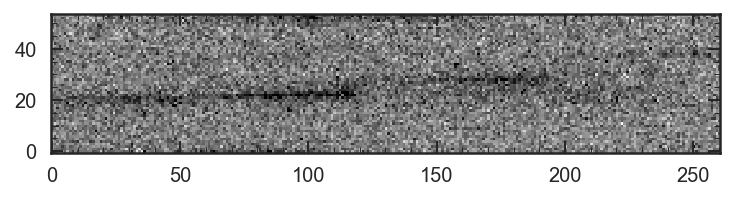

In [19]:
plt.imshow(dat[6].data,interpolation='none', vmin=-.1, vmax=0.1, 
           cmap='gray_r', origin='lower')

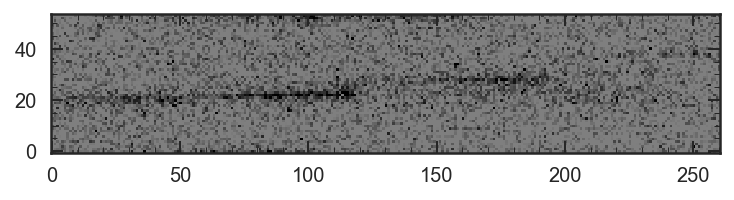

In [20]:
plt.imshow(clnr,interpolation='none', vmin=-.1, vmax=0.1, 
           cmap='gray_r', origin='lower')

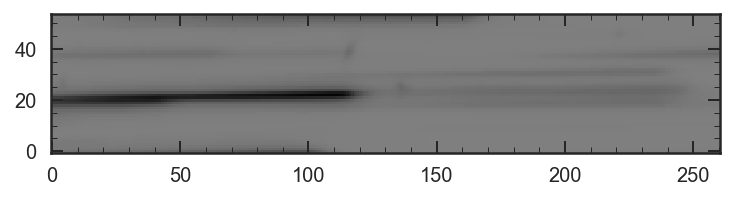

In [15]:
plt.imshow(dat[9].data,interpolation='none', vmin=-.1, vmax=0.1,  
           cmap='gray_r', origin='lower')

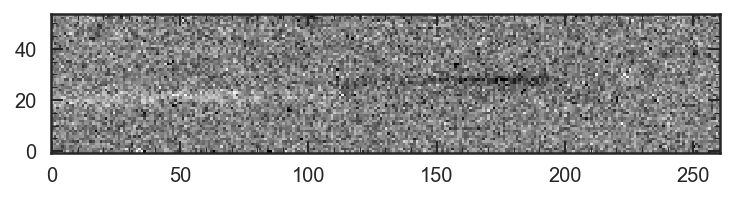

In [16]:
plt.imshow(dat[6].data - dat[9].data,interpolation='Nearest', vmin=-.1, vmax=0.1, 
           cmap='gray_r', origin='lower')

In [23]:
cln = dat[6].data - dat[9].data
cln[cln < 0] = 0

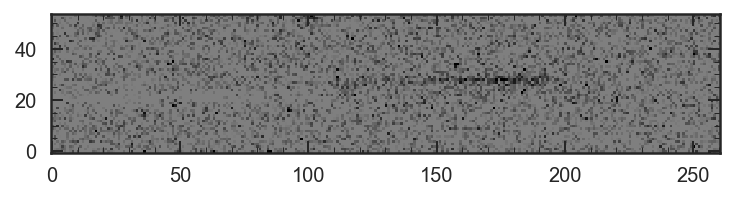

In [24]:
plt.imshow(cln,interpolation='none', vmin=-.1, vmax=0.1, 
           cmap='gray_r', origin='lower')

In [75]:
np.argwhere(dat[9].data== np.max(dat[9].data))

array([[ 22, 108]])

In [96]:
dat[6].data[15:25,105:110]

array([[-0.0101152 ,  0.00682136,  0.0023275 ,  0.03148388,  0.00672545],
       [-0.02555584, -0.04281157,  0.04732257,  0.03752683, -0.00693197],
       [ 0.0322256 ,  0.01266502, -0.00468214,  0.0124479 , -0.00975333],
       [ 0.01626782, -0.02781585, -0.00883755, -0.001622  ,  0.06707254],
       [-0.04707352, -0.0175242 ,  0.02165744,  0.00168506,  0.04652232],
       [ 0.05252657,  0.01712554,  0.03118848,  0.00657213,  0.05166406],
       [ 0.05362261,  0.00360825,  0.06294277,  0.04020489,  0.01313181],
       [ 0.15693158,  0.06124606,  0.13548137,  0.10816195,  0.13424796],
       [ 0.05943845,  0.06110931,  0.08928058,  0.04527279,  0.02463286],
       [ 0.00433291,  0.07468004,  0.04482781,  0.03722719,  0.03935521]],
      dtype=float32)

In [97]:
dat[9].data[15:25,105:110]

array([[0.00382715, 0.00380403, 0.00377751, 0.00374428, 0.00369653],
       [0.00726526, 0.00728037, 0.00728494, 0.00727185, 0.00722925],
       [0.01110285, 0.01113681, 0.01116555, 0.01117559, 0.01114752],
       [0.01634071, 0.01636046, 0.01636136, 0.01632803, 0.01624096],
       [0.02300556, 0.02293023, 0.02281353, 0.022645  , 0.02240737],
       [0.03830215, 0.03799717, 0.03763871, 0.0372108 , 0.03669114],
       [0.0697588 , 0.06928549, 0.0687798 , 0.06820817, 0.06752104],
       [0.09516983, 0.09526759, 0.09535223, 0.09538721, 0.09530714],
       [0.07752118, 0.07823528, 0.0789286 , 0.07956973, 0.08010448],
       [0.04099086, 0.04138526, 0.04173959, 0.04203662, 0.04224962]],
      dtype=float32)

In [99]:
np.sum(dat[6].data[15:25,105:110] - dat[9].data[15:25,105:110])

-0.36813992

In [5]:
model_wv,model_fl = np.load(hpath + 'fsps_models_for_fit/fsps_spec/m0.019_a1.6_dt0_spec.npy')

In [12]:
start = time()
sp.Gen_sim(model_wv, model_fl,1.61)
end = time()
print(end-start)

0.058055877685546875


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: divide by zero encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


In [7]:
wv1,fl1,er1 = np.load('multifit-g102.npy')
wv2,fl2,er2 = np.load('multifit-g141.npy')

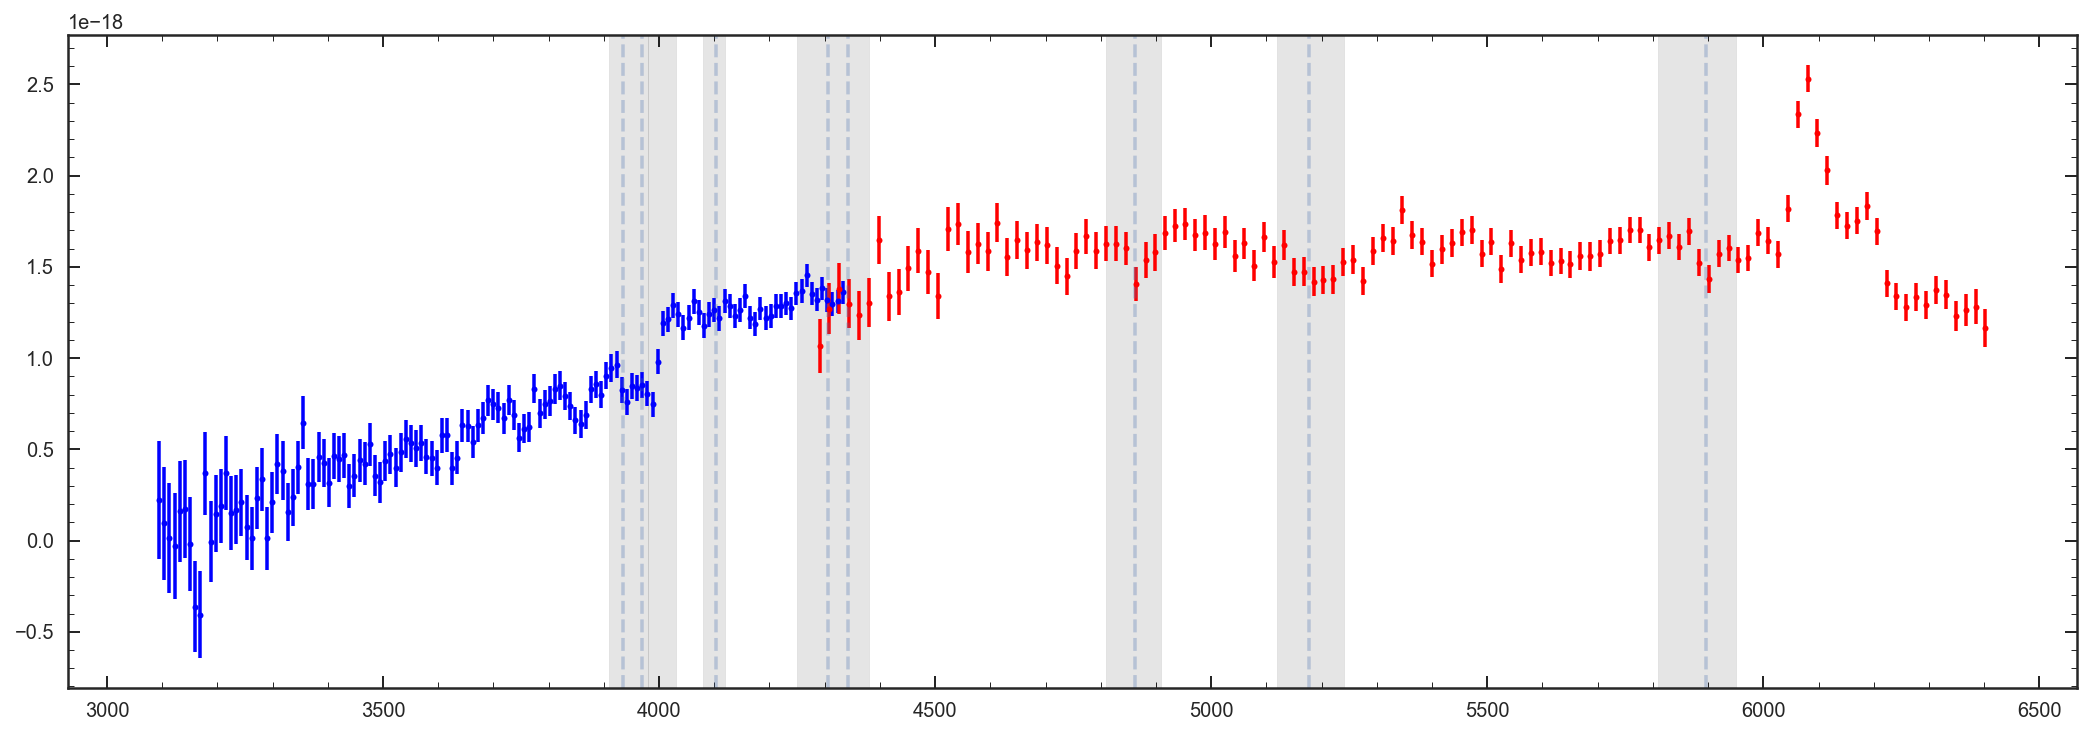

In [16]:
plt.figure(figsize=[18,6])
# plt.plot(sp.g102_wv,sp.g102_mfl)
plt.errorbar(sp.g102_wv/2.6,sp.g102_fl,sp.g102_er,linestyle='None', marker='o', markersize=3, color='b')
# plt.plot(sp.g141_wv,sp.g141_mfl)
plt.errorbar(sp.g141_wv/2.6,sp.g141_fl,sp.g141_er,linestyle='None', marker='o', markersize=3, color='r')
# plt.plot(wv1,fl1)
# plt.plot(sp.g102_wv,np.abs(interp1d(wv1,fl1)(sp.g102_wv)-sp.g102_fl))
plt.axvline(3934.777,linestyle='--', alpha=.3)
plt.axvline(3969.588,linestyle='--', alpha=.3)
plt.axvline(4102.89,linestyle='--', alpha=.3)
plt.axvline(4305.61,linestyle='--', alpha=.3)
plt.axvline(4341.68,linestyle='--', alpha=.3)
plt.axvline(4862.68,linestyle='--', alpha=.3)
plt.axvline(5176.7,linestyle='--', alpha=.3)
plt.axvline(5895.6,linestyle='--', alpha=.3)

plt.axvspan(3910, 3980, color='k', alpha=.1)
plt.axvspan(3980, 4030, color='k', alpha=.1)
plt.axvspan(4080, 4120, color='k', alpha=.1)
plt.axvspan(4250, 4380, color='k', alpha=.1)
plt.axvspan(4810, 4910, color='k', alpha=.1)
plt.axvspan(5120, 5240, color='k', alpha=.1)
plt.axvspan(5810, 5950, color='k', alpha=.1)

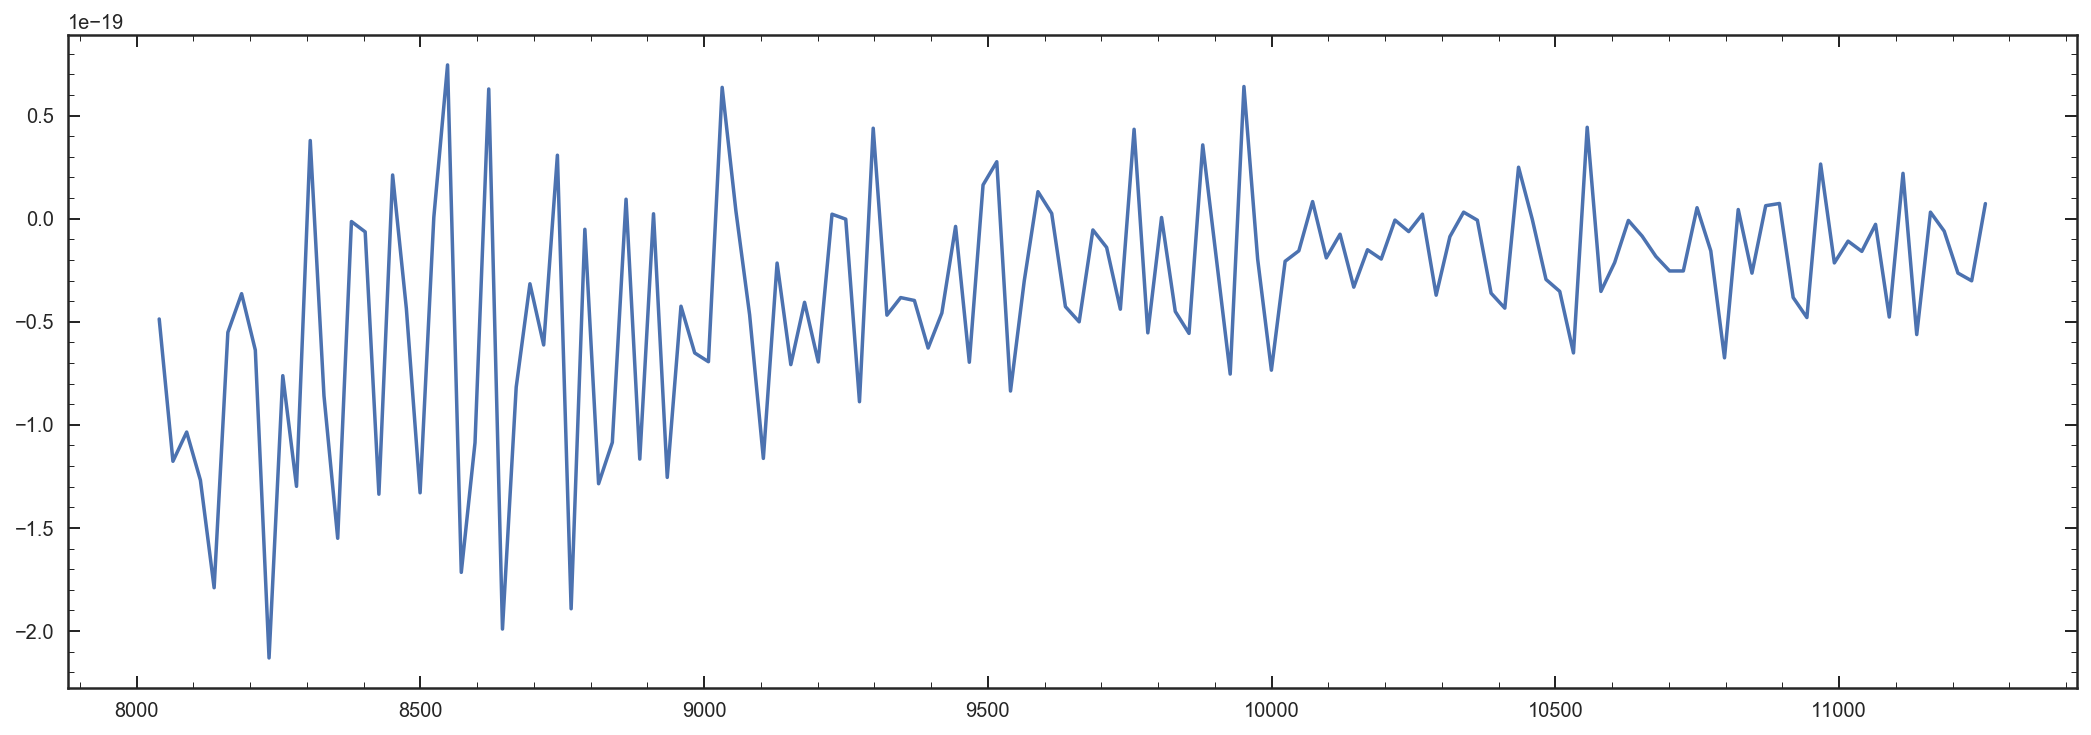

In [59]:
plt.figure(figsize=[18,6])
# plt.errorbar(sp.g102_wv,sp.g102_fl,sp.g102_er,linestyle='None', marker='o', markersize=3, color='b')
plt.plot(sp.g102_wv,interp1d(wv1,fl1)(sp.g102_wv)-sp.g102_fl)

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


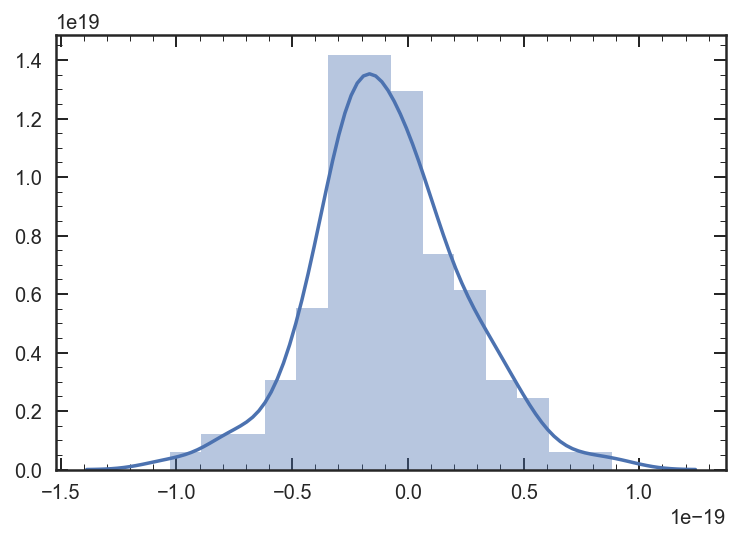

In [51]:
sea.distplot(interp1d(wv2,fl2)(sp.g141_wv)-sp.g141_fl)

In [50]:
start = time()
chi = np.sum(((sp.g102_fl - sp.g102_mfl) / sp.g102_er)**2) + np.sum(((sp.g141_fl - sp.g141_mfl) / sp.g141_er)**2)
end = time()
print(end-start)

AttributeError: 'Gen_spec' object has no attribute 'g102_mfl'

In [61]:
from grizli.multifit import GroupFLT, MultiBeam, get_redshift_fit_defaults

In [62]:
blist = glob('../beams/*41520*')

In [64]:
beams = []

for i in blist:
    beams.append(griz_model.BeamCutout(fits_file=i))

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3422: RuntimeWarning: invalid value encountered in sqrt
  resid = np.abs(self.scif - self.flat_flam)*np.sqrt(self.ivarf)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3427: RuntimeWarning: invalid value encountered in sqrt
  contam_mask = ((self.contam*np.sqrt(self.ivar) > contam_sn_mask[0]) &
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3428: RuntimeWarning: invalid value encountered in sqrt
  (self.model*np.sqrt(self.ivar) < contam_sn_mask[1]))


In [65]:
beams

In [81]:
mb = MultiBeam(beams, fcontam=1, group_name='ers-grism')

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1200: RuntimeWarning: divide by zero encountered in true_divide
  beam.ivarf = 1./(1/beam.ivarf + (sys_err*beam.scif)**2)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1328: RuntimeWarning: invalid value encountered in sqrt
  self.sivarf = np.sqrt(self.ivarf)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1333: RuntimeWarning: invalid value encountered in sqrt
  self.weightf = np.exp(-(self.fcontam*np.abs(self.contamf)*np.sqrt(self.ivarf)))
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:2948: FutureWarning: `rcond` parameter will change to the default of

In [82]:
g102_wave = np.array(mb.oned_spectrum()['G102']['wave'])
g141_wave = np.array(mb.oned_spectrum()['G141']['wave'])

IDX = [U for U in range(len(g102_wave)) if 8000< g102_wave[U] <11300]
IDC = [U for U in range(len(g141_wave)) if 11100< g141_wave[U] <16700]

g102_wave = g102_wave[IDX]
g141_wave = g141_wave[IDC]

g102_flux = mb.oned_spectrum()['G102']['flux'][IDX] / mb.oned_spectrum()['G102']['flat'][IDX]
g141_flux = mb.oned_spectrum()['G141']['flux'][IDC] / mb.oned_spectrum()['G141']['flat'][IDC]

g102_err = mb.oned_spectrum()['G102']['err'][IDX] / mb.oned_spectrum()['G102']['flat'][IDX]
g141_err = mb.oned_spectrum()['G141']['err'][IDC] / mb.oned_spectrum()['G141']['flat'][IDC]

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: divide by zero encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


<ErrorbarContainer object of 3 artists>

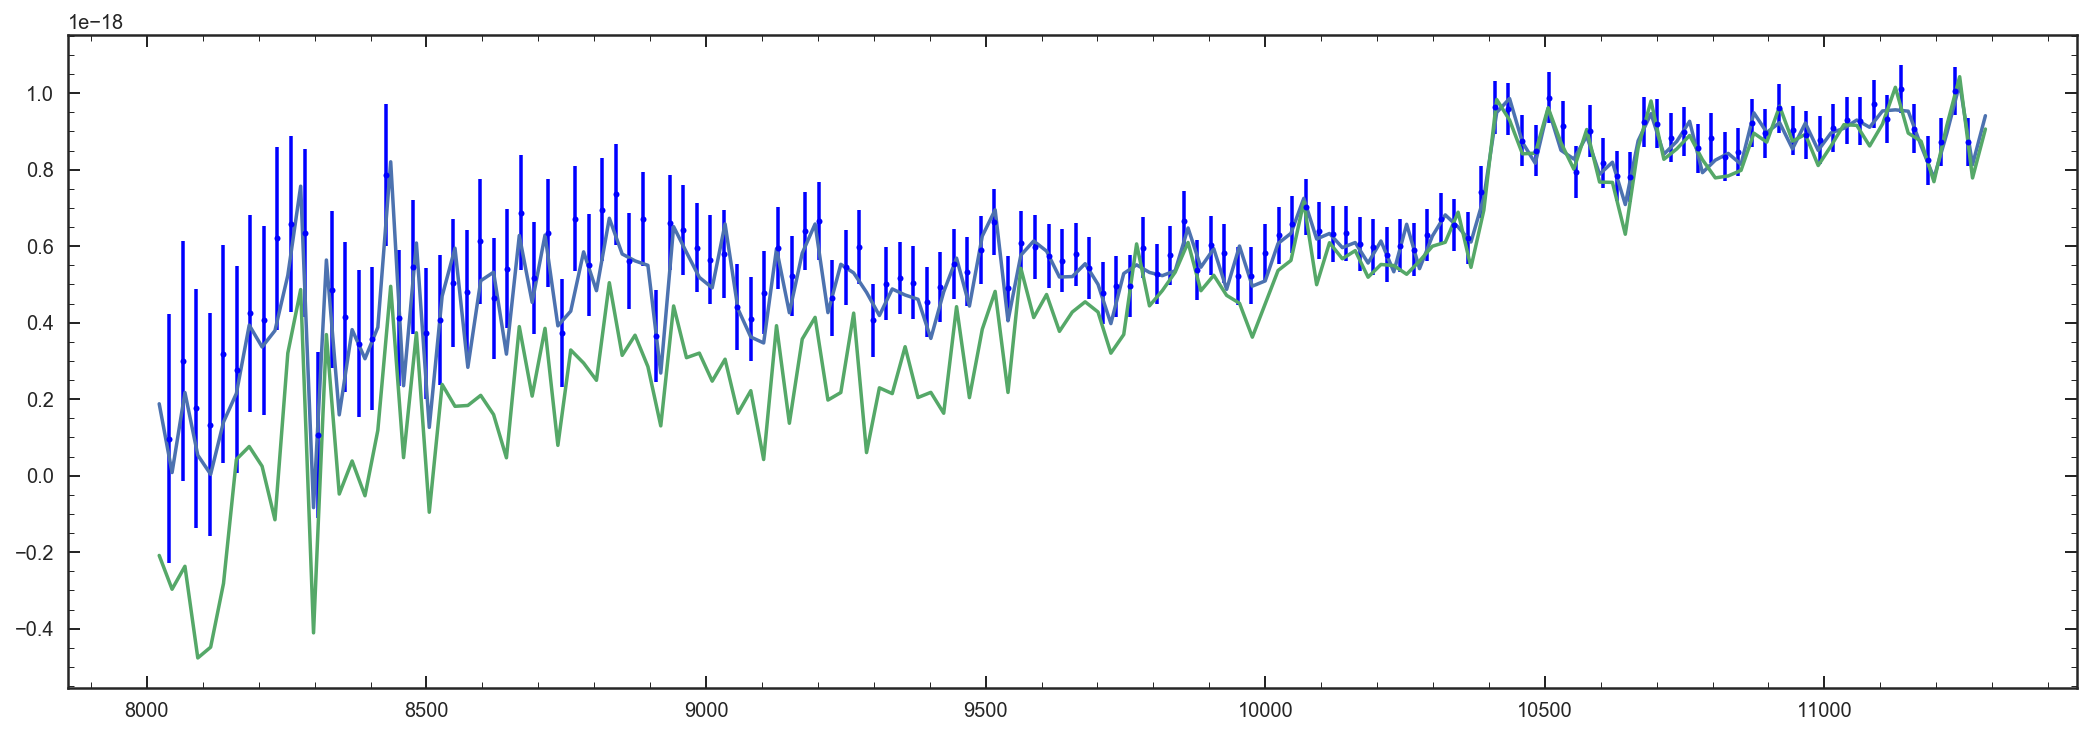

In [85]:
plt.figure(figsize=[18,6])
plt.plot(wv1,fl1)
plt.plot(g102_wave,g102_flux*1.1)
plt.errorbar(sp.g102_wv,sp.g102_fl,sp.g102_er,linestyle='None', marker='o', markersize=3, color='b')
